# First attempt for implementation of "A faster algorithm for the calculation of the fast spectral correlation" by P. Borghesani & J. Antoni 

In [1]:
import numpy as np
from scipy.signal import iirfilter, lfilter, periodogram, stft

import matplotlib.pyplot as plt
# %matplotlib notebook
figsize = [19, 5]

# sampling rate
fs = 10**6
nSamples = 10**6

modFreq = 50
carrierFreq = 225e+3
bandWidth = 25e+3
filtOrd = 2
nHarmonics = 20
filtWn = [(carrierFreq - bandWidth) / (fs / 2), (carrierFreq + bandWidth) / (fs / 2)]

### signal simulation - noise modulating with 50 Hz

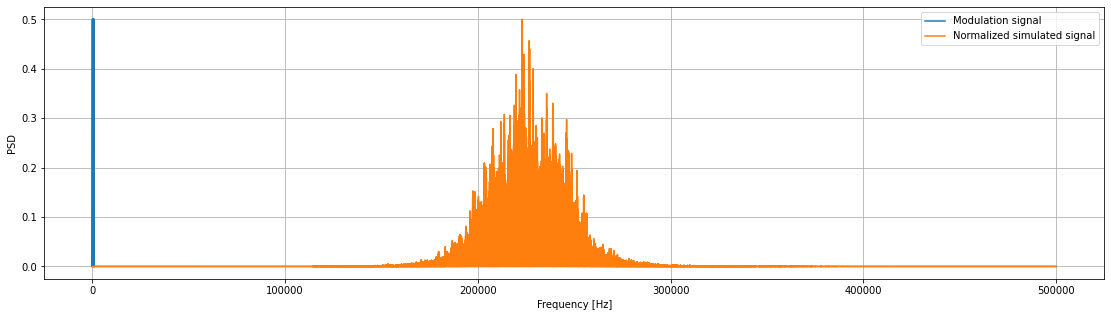

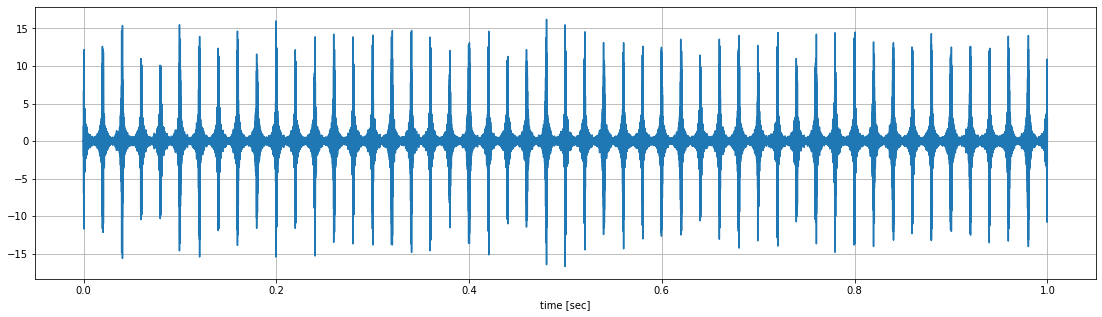

In [2]:
t = np.arange(nSamples) / fs

x = np.zeros_like(t)
for h in range(1, nHarmonics):
    x += np.sin(h * modFreq * np.pi * 2 * t) 

plt.figure(figsize=figsize)
f, pxx = periodogram(x, fs)
plt.plot(f, pxx)

x *= np.random.randn(t.shape[0])
b, a = iirfilter(filtOrd, filtWn)
x = lfilter(b, a, x)

f, pxx = periodogram(x, fs)
plt.plot(f, pxx / pxx.max() * 0.5)
plt.grid()
# plt.xlim([0, h * modFreq])
plt.legend(['Modulation signal', 'Normalized simulated signal'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=figsize)
plt.plot(t, x)
plt.grid()
plt.xlabel('time [sec]')
plt.show()

### here I create the same signal for the second time for another figure - zoom view

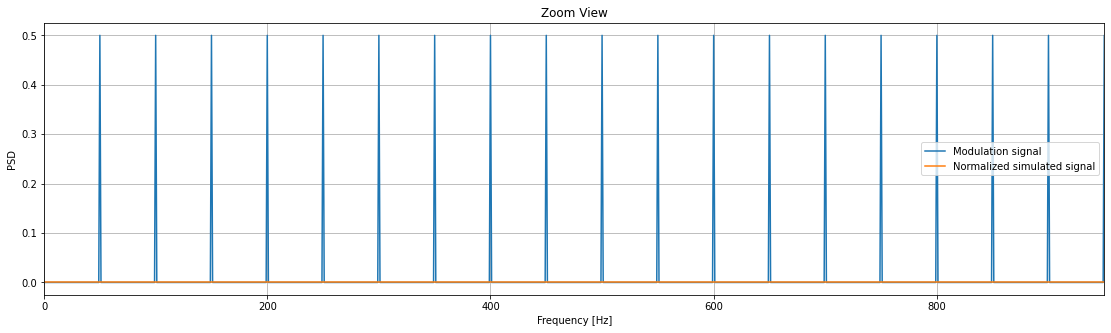

In [3]:
x = np.zeros_like(t)
for h in range(1, nHarmonics):
    x += np.sin(h * modFreq * np.pi * 2 * t) 

plt.figure(figsize=figsize)
f, pxx = periodogram(x, fs)
plt.plot(f, pxx)

x *= np.random.randn(t.shape[0])
b, a = iirfilter(filtOrd, filtWn)
x = lfilter(b, a, x)

f, pxx = periodogram(x, fs)
plt.plot(f, pxx / pxx.max() * 0.5)
plt.grid()
# plt.xlim([0, h * modFreq])
plt.title('Zoom View')
plt.legend(['Modulation signal', 'Normalized simulated signal'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim([0, h * modFreq])
plt.show()

In [43]:
def getParams (alphaMax=1000, df=100, fMin=5e+4):
    # alphaMax - max modulation frequency
    # df - carrier frequency resolution
    # fMin - min carrier frequency

    # STFT windows' hop
    R = int(np.floor(fs / (2 * alphaMax))) #shift of the stft
    # STFT window length
    Nw = int(fs / df)
    # number of STFT windows
#     M = int((x.size - Nw) / R + 1)

    # hannind window
    w = np.hanning(Nw)
    # Dirichlet kernel parameter
    P = int(np.round((Nw - 1) / (2 * R)))
    # Dirichlet kernel
    D = np.sum(
        [np.exp(2 * np.pi * 1j * p *(np.arange(Nw) - Nw / 2) / Nw) for p in np.arange(- P, P + 1)], 
        axis=0
    )
    D = D.real
    return fMin, R, Nw, w, D

In [45]:
fMin, R, Nw, w, D = getParams(alphaMax=1000, df=100, fMin=5e+4)

dtype('float64')

In [22]:
from numpy.lib.stride_tricks import sliding_window_view

def getCS(x, fs, norm=False):
    fMin, R, Nw, w, D = getParams()
    # buffering
    bufferX = sliding_window_view(x, (Nw, ), )[::R, :]

    # x_w
    bufferX_w = np.multiply(bufferX, w)
    # x_w^P
    bufferX_wD = np.multiply(bufferX, w * D)

    alpha = np.fft.fftfreq(bufferX.shape[0], R / fs)
    f = np.fft.fftfreq(bufferX.shape[1], 1 / fs)

    X_w   = np.fft.fft(bufferX_w, axis=1)
    x_w_d = np.fft.fft(bufferX_wD, axis=1)

    X_w = X_w[:, f >= fMin]
    x_w_d = x_w_d[:, f >= fMin]
    
    if norm:
        X_w = np.divide(X_w, np.sum(np.abs(X_w), axis=0))
        x_w_d = np.divide(x_w_d, np.sum(np.abs(x_w_d), axis=0))

    CS = np.fft.fft(np.conjugate(X_w) * x_w_d, axis=0)
    CS = CS[alpha >= 0, :]

    alpha = alpha[alpha >= 0]
    f = f[f >= fMin]
    
    return CS, f, alpha
# K = np.abs(np.fft.fft((w**2) * D)[:alpha.size])
# CS = np.divide(CS.T, K * fs * M)

In [23]:
from numpy.lib.stride_tricks import sliding_window_view

def getCS_CMS(x, fs, norm=False):
    fMin, R, Nw, w, D = getParams()
    # buffering
    bufferX = sliding_window_view(x, (Nw, ), )[::R, :]

    # x_w
    bufferX_w = np.multiply(bufferX, w)
    # x_w^P
    bufferX_wD = np.multiply(bufferX, w * D)

    alpha = np.fft.fftfreq(bufferX.shape[0], R / fs)
    f = np.fft.fftfreq(bufferX.shape[1], 1 / fs)

    X_w   = np.fft.fft(bufferX_w, axis=1)
    X_w = X_w[:, f >= fMin]
    
    if norm:
        X_w = np.divide(X_w, np.sum(np.abs(X_w), axis=0))

    CS_CMS = np.fft.fft(X_w * np.conjugate(X_w), axis=0)
    CS_CMS = CS_CMS[alpha >= 0, :]

    alpha = alpha[alpha >= 0]
    f = f[f >= fMin]
    
    return CS_CMS, f, alpha

In [17]:
%timeit fMin, R, Nw, w, D = getParams()

/var/folders/y7/k3j5759x5qlb_s8xycr9yln80000gq/T/ipykernel_73486/2312078924.py:18: RuntimeWarning: invalid value encountered in true_divide
  D = np.sin((2 * P + 1) * np.pi * (np.arange(Nw) - Nw / 2) / Nw) / np.sin(np.pi * (np.arange(Nw) - Nw / 2) / Nw)


447 µs ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit CS_CMS, f, alpha = getCS_CMS(x, fs, Nw, R, w, fMin, norm=True)

759 ms ± 68.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# %timeit CS, f, alpha = getCS(x, fs, Nw, R, w, D, norm=True)

In [10]:
CS, f, alpha = getCS(x, fs, Nw, R, w, D, fMin, norm=False)
CCoh, f, alpha = getCS(x, fs, Nw, R, w, D, fMin, norm=True)
CS_CMS, f, alpha = getCS_CMS(x, fs, Nw, R, w, fMin, norm=False)
CCoh_CMS, f, alpha = getCS_CMS(x, fs, Nw, R, w, fMin, norm=True)

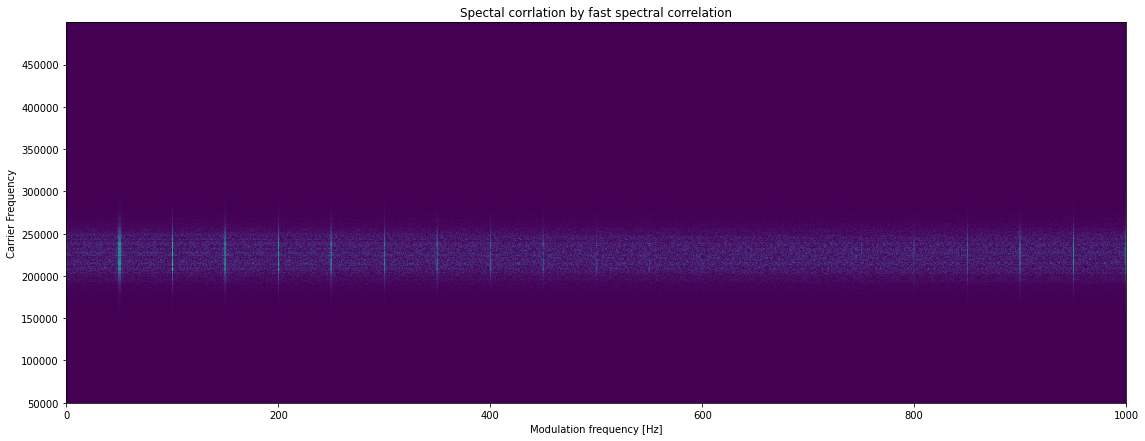

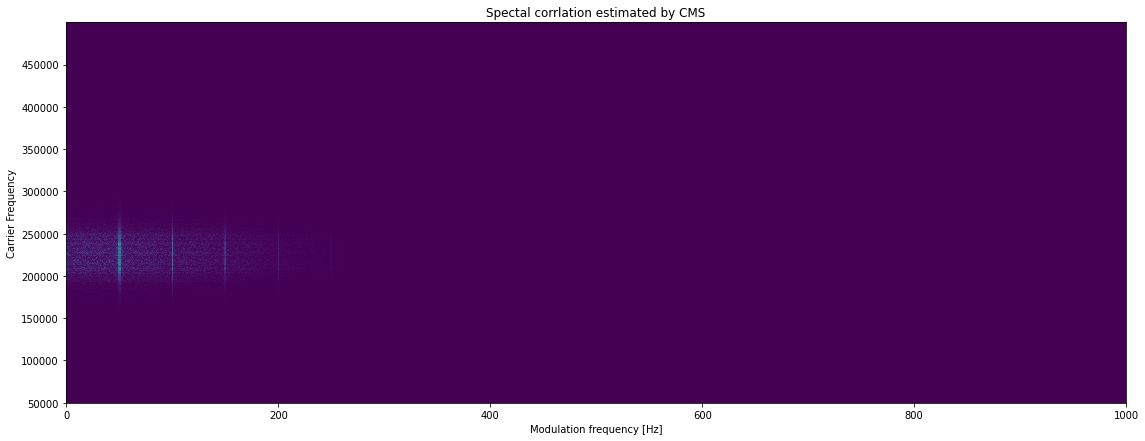

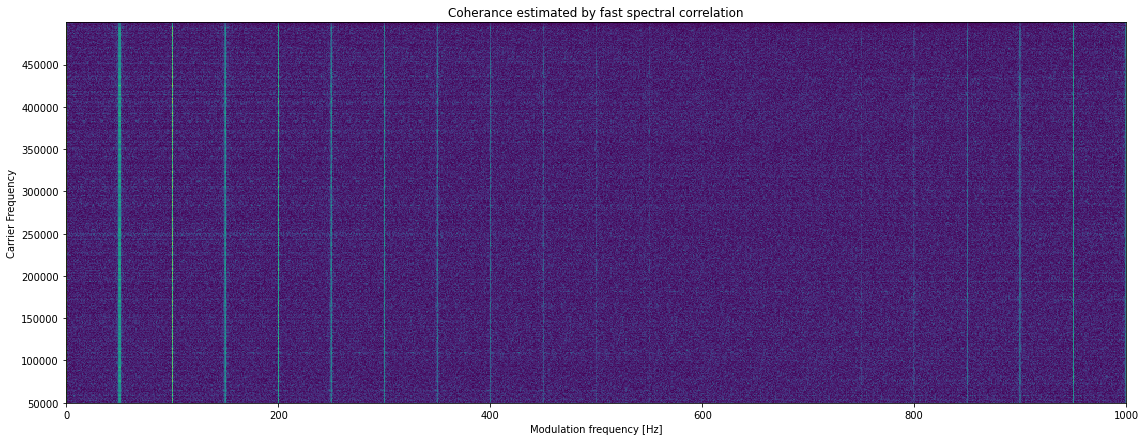

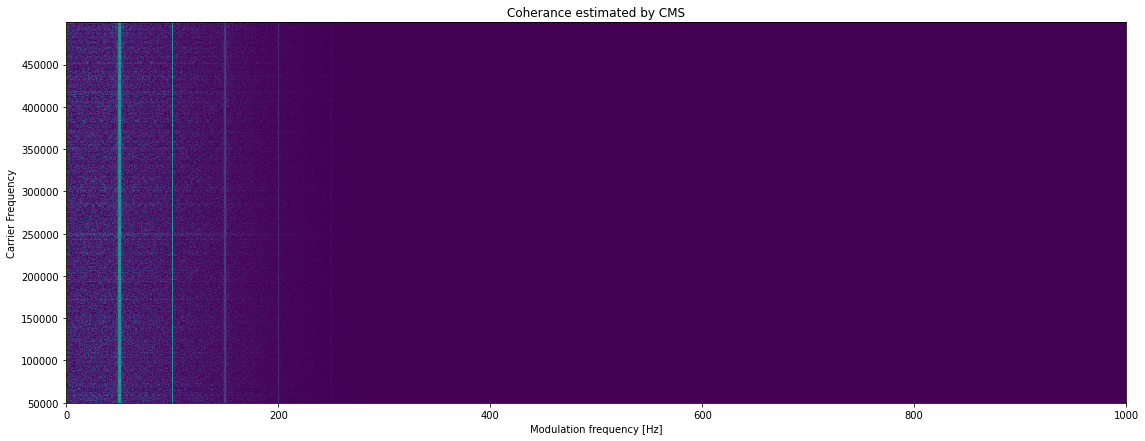

In [11]:
%matplotlib inline
figsize = [19, 7]
plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CS.T))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal corrlation by fast spectral correlation')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CS_CMS.T))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal corrlation estimated by CMS')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CCoh.T))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Coherance estimated by fast spectral correlation')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CCoh_CMS.T))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Coherance estimated by CMS')
plt.show()

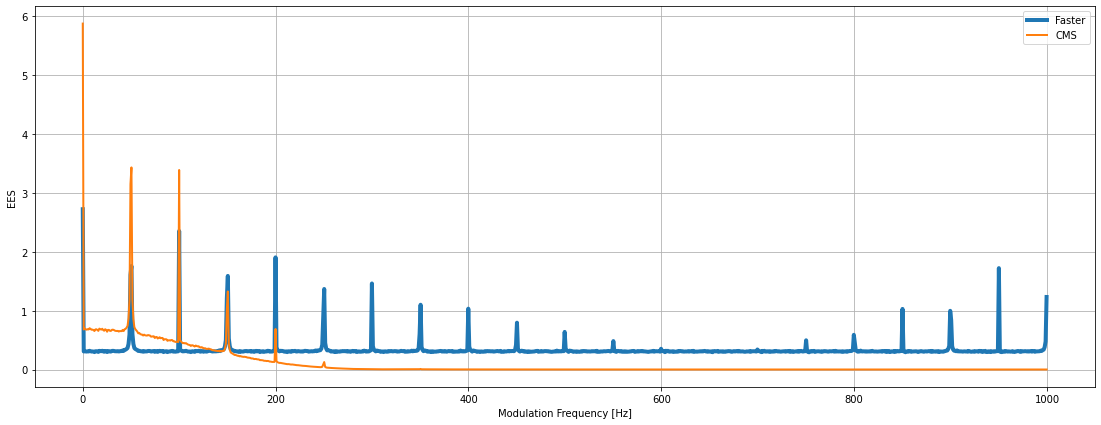

In [12]:
plt.figure(figsize=figsize)
plt.plot(alpha, np.sum(np.abs(CCoh), axis=1), linewidth=4)
plt.plot(alpha, np.sum(np.abs(CCoh_CMS), axis=1), linewidth=2)
plt.xlabel('Modulation Frequency [Hz]')
plt.ylabel('EES')
plt.legend(['Faster', 'CMS'])
plt.grid()
plt.show()